# 数据挖掘互评作业二: 频繁模式与关联规则挖掘


姓名：李荣荣   
学号：3220211029

## 数据集选择：Wine Reviews

## Step 1：数据集分析
    该数据集共包含十个属性，其中country、designation、province、region_1、region_2、variety和winery为标称属性， points和price为数值属性：
    （1）country：酒的国家
    （2）description：收集的对酒的描述，包括味道、气味、外观、感觉等；
    （3）designation：酿制葡萄酒的葡萄产地；
    （4）points：葡萄酒爱好者对这款酒的评分范围为1至100分(不过他们表示，他们只会对>=80分的葡萄酒发表评论)；
    （5）price：一瓶酒的价格；
    （6）province：产酒的省或州；
    （7）region_1：一个省或州的葡萄酒产区；
    （8）region_2：有时，在一个葡萄酒种植区中指定了更具体的区域，但这个值有时可以是空的；
    （9）variety：用来酿酒的葡萄品种；
    （10）winery：生产酒的酿酒厂；

In [41]:
import pandas as pd
import numpy as np 
winedata = pd.read_csv('D:/Python/jupyter-notebook/data/winemag-data_first150k.csv')

winedata = winedata.dropna()
winedata.head(n=100)    #显示前100行

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm
...,...,...,...,...,...,...,...,...,...,...,...
263,263,US,Oso Libre ventures into the nonvintage categor...,Primoroso,88,39.0,California,Paso Robles,Central Coast,Red Blend,Oso Libre
267,267,US,"A brighter, more mineral- and acid-driven take...",Anna's Estate Vineyard,88,32.0,California,Paso Robles,Central Coast,Mourvèdre,Adelaida
272,272,US,The southern Napa Coombsville area is near San...,Haynes Vineyard,92,58.0,California,Coombsville,Napa,Chardonnay,Failla
273,273,US,"From the estimable Shake Ridge Ranch, winemake...",Suzuri Series Shake Ridge Ranch,92,50.0,California,Amador County,Sierra Foothills,Rhône-style Red Blend,Gallica


In [42]:
winedata.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


**去除序号（0），以及无法补充的description（2）**

In [43]:
#去除显然为独特信息，无法依靠统计填补缺失的（未命名列）序号、description列数据
winedata = winedata.drop(columns=['Unnamed: 0','description'])

winedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39241 non-null  object 
 1   designation  39241 non-null  object 
 2   points       39241 non-null  int64  
 3   price        39241 non-null  float64
 4   province     39241 non-null  object 
 5   region_1     39241 non-null  object 
 6   region_2     39241 non-null  object 
 7   variety      39241 non-null  object 
 8   winery       39241 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 3.0+ MB


## Step 2：数据集处理

先观察发现 points：酒的评分， price：酒的价格，均为连续型数据，需要对这两个连续特征转化为离散型处理

Text(0.5, 1.0, 'points')

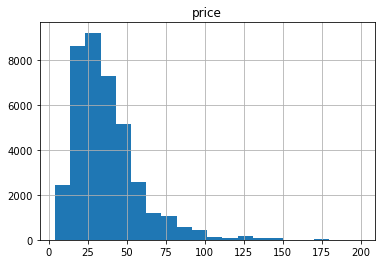

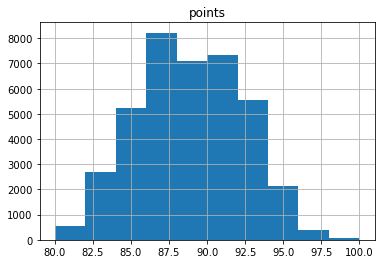

In [44]:
import matplotlib.pyplot as plt
winedata['price'].loc[winedata['price']<200].hist(bins=20)
plt.title("price")
plt.figure()
winedata['points'].hist()
plt.title("points")

首先处理 price

In [45]:
#进行离散化分段处理：cut函数
bin = [0,20,30,40,50,60,200]
winedata['price'] = pd.cut(winedata['price'],bin)
winedata['price'] = winedata['price'].astype('str')

In [46]:
#进行离散化分段处理：cut函数
bin = [0,75,80,85,90,95,100]
winedata['points'] = pd.cut(winedata['points'],bin)
winedata['points'] = winedata['points'].astype('str')

## Step 3：找出频繁模式

使用Aprior算法

In [47]:
def createC1( dataSet ):
    """
    构建初始候选项集的列表，即所有候选项集只包含一个元素，
    C1是大小为1的所有候选项集的集合
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

In [48]:
# Aprior算法
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

输出频繁项集的列表

In [40]:

# 支持度大于0.1的频繁项集
myDat = list(map(set,np.array(winedata)))
L, suppData = apriori(myDat, 0.1)
L

[[frozenset({'(80, 85]'}),
  frozenset({'(0, 20]'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20, 30]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40, 50]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Sonoma'}),
  frozenset({'(60, 200]'}),
  frozenset({'US'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'})],
 [frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'US'}),
  frozenset({'(85, 90]', 'Central Coast'}),
  frozenset({'(0, 20]', 'California'}),
  frozenset({'(0, 20]', 'US'}),
  frozenset({'(0, 20]', '(85, 90]'}),
  frozenset({'(20, 30]', '(85, 90]'}),
  frozenset({'(30, 40]', 'California'}),
  frozenset({'(30, 40]', 'US'}),
  frozenset({'(85, 90]', 'California'}),
  frozenset({'(85, 90]', 'US'}),
  frozenset({'(30, 40]', '(85, 90]'}),
  frozenset({'Columbia Valley', 'US'}),
 

## Step 4：计算支持度和置信度

In [49]:
suppData

{frozenset({'Cabernet Sauvignon'}): 0.12476746260288983,
 frozenset({'California'}): 0.7277337478657526,
 frozenset({'Napa'}): 0.13016997528095614,
 frozenset({'US'}): 1.0,
 frozenset({'(60, 200]'}): 0.10178130017073979,
 frozenset({'Sonoma'}): 0.19841492316709564,
 frozenset({'Pinot Noir'}): 0.19000535154557732,
 frozenset({'(90, 95]'}): 0.271476262072832,
 frozenset({'(40, 50]'}): 0.147549756632094,
 frozenset({'Chardonnay'}): 0.1247419790525216,
 frozenset({'(20, 30]'}): 0.24296016921077446,
 frozenset({'Central Coast'}): 0.2331744858693713,
 frozenset({'Columbia Valley'}): 0.1474223388802528,
 frozenset({'Washington'}): 0.15601029535434877,
 frozenset({'(30, 40]'}): 0.19823653831451798,
 frozenset({'(85, 90]'}): 0.5018730409520654,
 frozenset({'(0, 20]'}): 0.23786345913712698,
 frozenset({'(80, 85]'}): 0.209729619530593,
 frozenset({'Napa', 'US'}): 0.13016997528095614,
 frozenset({'California', 'US'}): 0.7277337478657526,
 frozenset({'Cabernet Sauvignon', 'US'}): 0.1247674626028898

置信度计算

In [50]:
confList = []
for itemSet in L:
    for record in itemSet:
        if(len(record)>1): 
            for i in record: 
                tar = suppData[frozenset([i])]
                bset = record - frozenset([i])
                aset = suppData[record]
                ret = suppData.get(bset)
                try:
                    if suppData.get(bset):
                        con = aset/ret
                        print(frozenset([i]),record,con)
                        confList.append([frozenset([i]),record,con])
                except TypeError as e:
                    print(e)
                    

frozenset({'California'}) frozenset({'California', '(80, 85]'}) 0.8234507897934387
frozenset({'(80, 85]'}) frozenset({'California', '(80, 85]'}) 0.2373148439962181
frozenset({'US'}) frozenset({'US', '(80, 85]'}) 1.0
frozenset({'(80, 85]'}) frozenset({'US', '(80, 85]'}) 0.209729619530593
frozenset({'(85, 90]'}) frozenset({'(85, 90]', 'Central Coast'}) 0.4743169398907104
frozenset({'Central Coast'}) frozenset({'(85, 90]', 'Central Coast'}) 0.22037168680816493
frozenset({'California'}) frozenset({'California', '(0, 20]'}) 0.6584529676451681
frozenset({'(0, 20]'}) frozenset({'California', '(0, 20]'}) 0.21521868543614525
frozenset({'US'}) frozenset({'US', '(0, 20]'}) 1.0
frozenset({'(0, 20]'}) frozenset({'US', '(0, 20]'}) 0.23786345913712698
frozenset({'(85, 90]'}) frozenset({'(85, 90]', '(0, 20]'}) 0.5366402399828584
frozenset({'(0, 20]'}) frozenset({'(85, 90]', '(0, 20]'}) 0.25434142378389357
frozenset({'(85, 90]'}) frozenset({'(85, 90]', '(20, 30]'}) 0.5878959513320746
frozenset({'(20, 3

## Step 5：对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种

### Lift


In [51]:
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[1])/(suppData.get(item[0])*suppData.get(item[1]-item[0]))
        if score>1:
            liftList_true.append(item)
        if score<1:
            liftList_false.append(item)
        if score ==1:
            liftList_no.append(item)
    return liftList_true,liftList_no,liftList_false

In [52]:
yes,no,false = liftCheck(confList,suppData)

In [38]:
##查看正相关的关联规则
yes

[[frozenset({'California'}),
  frozenset({'(80, 85]', 'California'}),
  0.8234507897934387],
 [frozenset({'(80, 85]'}),
  frozenset({'(80, 85]', 'California'}),
  0.2373148439962181],
 [frozenset({'(85, 90]'}),
  frozenset({'(0, 20]', '(85, 90]'}),
  0.5366402399828584],
 [frozenset({'(0, 20]'}),
  frozenset({'(0, 20]', '(85, 90]'}),
  0.25434142378389357],
 [frozenset({'(85, 90]'}),
  frozenset({'(20, 30]', '(85, 90]'}),
  0.5878959513320746],
 [frozenset({'(20, 30]'}),
  frozenset({'(20, 30]', '(85, 90]'}),
  0.28460444805524526],
 [frozenset({'California'}),
  frozenset({'(30, 40]', 'California'}),
  0.7551099112996529],
 [frozenset({'(30, 40]'}),
  frozenset({'(30, 40]', 'California'}),
  0.2056938754070806],
 [frozenset({'(30, 40]'}),
  frozenset({'(30, 40]', '(85, 90]'}),
  0.21052097085406724],
 [frozenset({'(85, 90]'}),
  frozenset({'(30, 40]', '(85, 90]'}),
  0.5329733898958735],
 [frozenset({'Washington'}),
  frozenset({'Columbia Valley', 'Washington'}),
  1.0],
 [frozenset({

### 全自信度

In [15]:
def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/max(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append(['全自信度为:{0}'.format(score),item])
    return result

In [16]:
conf = all_confidence(confList,suppData)
conf

[['全自信度为:0.2373148439962181',
  [frozenset({'California'}),
   frozenset({'(80, 85]', 'California'}),
   0.8234507897934387]],
 ['全自信度为:0.2373148439962181',
  [frozenset({'(80, 85]'}),
   frozenset({'(80, 85]', 'California'}),
   0.2373148439962181]],
 ['全自信度为:0.209729619530593',
  [frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0]],
 ['全自信度为:0.209729619530593',
  [frozenset({'(80, 85]'}), frozenset({'(80, 85]', 'US'}), 0.209729619530593]],
 ['全自信度为:0.22037168680816493',
  [frozenset({'(85, 90]'}),
   frozenset({'(85, 90]', 'Central Coast'}),
   0.4743169398907104]],
 ['全自信度为:0.22037168680816493',
  [frozenset({'Central Coast'}),
   frozenset({'(85, 90]', 'Central Coast'}),
   0.22037168680816493]],
 ['全自信度为:0.21521868543614525',
  [frozenset({'California'}),
   frozenset({'(0, 20]', 'California'}),
   0.6584529676451681]],
 ['全自信度为:0.21521868543614525',
  [frozenset({'(0, 20]'}),
   frozenset({'(0, 20]', 'California'}),
   0.21521868543614525]],
 ['全自信度为:0.23786345913712698',
  [

## Step 6：可视化展示

支持度与置信度可视化

In [17]:
item = conf[0]
support = item[1][2]
confidence = item[0].split(':')[1]

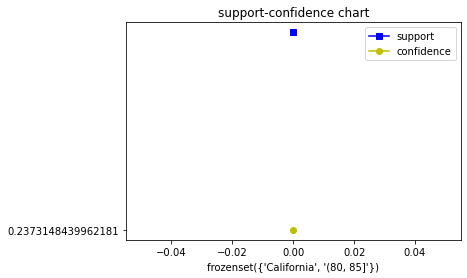

In [18]:
k1 = support 
k2 = confidence  
plt.plot( k1, 's-', color = 'b', label="support")  
plt.plot( k2, 'o-', color = 'y', label="confidence")  
plt.xlabel(item[1][1]) 
plt.legend(loc="best") 
plt.title("support-confidence chart")
plt.show()

## Step 7：实验分析

#### 本实验通过Apriori算法按照support，confidence，LIFT等指标计算出了频繁项集和他们之间的关系，挖掘出了关于葡萄酒产地与评分、与价格之间的关系

#### 结果分析
经过预处理后，保留的数据均为US的葡萄酒的数据。

根据频繁项集的结果可以看出，
百分之八十五的葡萄酒的价格在50以内，约百分之事物的葡萄酒的价格在50到100,约百分之一的葡萄酒的价格超过100；
百分之七十的葡萄酒来自California, 百分之十六的葡萄酒来自Washington；
在价格不超过50的葡萄酒中，约六十八的葡萄酒来自California，约百分之十八的葡萄酒来自Washington；
约百分之十七的葡萄酒是由Pinot Noir酿造的；
评分为87的葡萄酒中约百分之九十的价格不超过50，评分为88的葡萄酒中约百分之九十一的价格不超过50，评分为90的葡萄酒中约百分之八十四的价格不超过50。

根据关联规则的结果可以看出，
百分之九十九由Sauvignon Blanc、Riesling酿造的葡萄酒的价格在50以内；
约百分之九十八的评分为82、83的葡萄酒的价格在50以内，
约百分之九十六的评分为84、85的葡萄酒的价格在50以内，
约百分之八十九的评分为89的葡萄酒的价格在50以内，可以看出，随着评分的提升，葡萄酒价格在50以内的占比越来越少，
说明随着评分提高，葡萄酒的价格也相对提升；